In [1]:
import dirfile_functions as df
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d

In [2]:
%matplotlib notebook
# Make default be interactive plots
# %matplotlib inline

In [3]:
df = reload(df)

In [4]:
roach_path = 'roach_data/'
ancillary_path = 'xy_stage/'

In [5]:
# Load some data, using both the dirfile functions and the direct method.  Compute both amplitude and phase.
chan = 0
which_scans = 'x'
I, Q = df.loadIQsingleChan(roach_path, chan)
d_roach = gd.dirfile(roach_path, gd.RDWR|gd.UNENCODED)
mag = np.sqrt(I**2 + Q**2)
phs = np.arctan2(Q,I)

i_kid0300_roach3 q_kid0300_roach3


In [6]:
# Get the x-y stage data
d_anc = gd.dirfile(ancillary_path, gd.RDWR|gd.UNENCODED)
x_stage = d_anc.getdata('x_stage', gd.FLOAT32) #, num_frames = d.nframes)
y_stage = d_anc.getdata('y_stage', gd.FLOAT32)

In [7]:
# Mod
#x_stage[x_stage > 8500] = x_stage[x_stage > 8500] - 8500
#y_stage[y_stage > 8500] = y_stage[y_stage > 8500] - 8500
# Fold
#x_stage -= 3000
#y_stage -= 3000
#s_mid = 7000
#s_max = 14000
#x_stage[x_stage > s_mid] = s_max - x_stage[x_stage > s_mid]
#y_stage[y_stage > s_mid] = s_max - y_stage[y_stage > s_mid]

In [8]:
# Generate the time axis appropriate for each variable under the assumption I know the sample rates
t488 = np.arange(len(Q))/df.fs
t5 = np.arange(len(x_stage))/5.

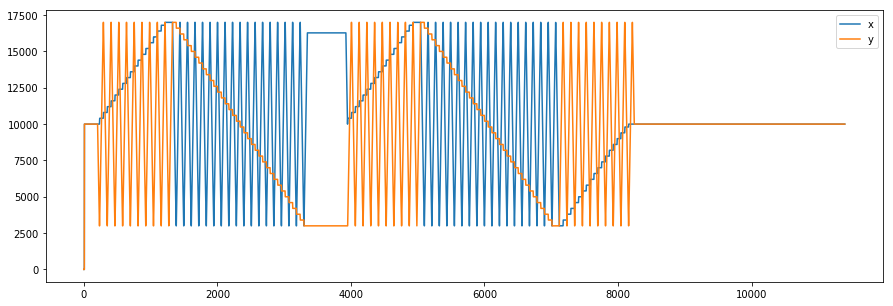

In [9]:
# Plot the x and y stage positions versus time
#%matplotlib notebook
plt.figure(figsize=(15,5))
plt.plot(t5,x_stage,label='x')
plt.plot(t5,y_stage,label='y')
plt.legend()
plt.show()

In [10]:
print x_stage[t5 > 1000].min()
print y_stage[t5 > 1000].min()
print x_stage[t5 > 1000].max()
print y_stage[t5 > 1000].max()

3000.0
3000.0
17000.0
17000.0


This scan pattern is just weird.  It looks like x moves over half its range in slow steps, with fast y scanning, then we switch to fast x scanning while y moves down slowly to the edge of its range, then y scans fast while x moves over the other part of the range.  It also looks like this pattern repeats not quite twice. 

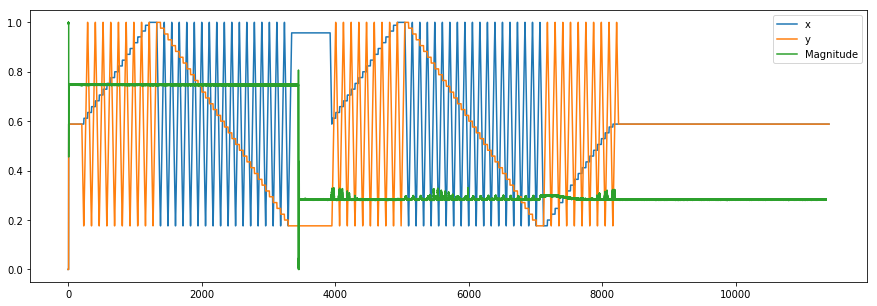

In [11]:
# Plot the signal on the x-y stage motions (channel 1)
#%matplotlib notebook
plt.figure(figsize=(15,5))
plt.plot(t5,x_stage/x_stage.max(),label='x')
plt.plot(t5,y_stage/y_stage.max(),label='y')
plt.plot(t488,mag/mag.max(),label='Magnitude')
plt.legend()
plt.show()

I don't see evidence for any signal in the first scan pattern.  There _is_ signal in the second, but as we'll see below, the pattern for when it appears doesn't make sense.

In [12]:
# I'm going to define the two chunks I see by hand (in seconds)
# This part is _super_ not general and very ugly
# The +1 is for later definition, so that there's always a x/y stage position for any detector value
# move which scans to top for faster reexecution
#which_scans = 'x'
chunk1 = [180,3350]
if which_scans == 'x':
    chunk2 = [5040,7120] # Sam's range
if which_scans == 'xy':
    chunk2 = [3940,8250] # full range
if which_scans == 'x' or which_scans == 'xy':
    wh2_5 = np.logical_and(t5 > chunk2[0], t5 < chunk2[1])
    wh2_488 = np.logical_and(t488 > chunk2[0]+1, t488 < chunk2[1]-1)
    
if which_scans == 'y':
    wh2_5 = np.logical_or(np.logical_and(t5 > 3940, t5 < 5040),np.logical_and(t5 > 7120, t5 < 8250) )
    wh2_488 = np.logical_or(np.logical_and(t488 > 3940+1, t488 < 5040-1),np.logical_and(t488 > 7120+1, t488 < 8250-1) )

wh1_5 = np.logical_and(t5 > chunk1[0], t5 < chunk1[1])
wh1_488 = np.logical_and(t488 > chunk1[0]+1, t488 < chunk1[1]-1)

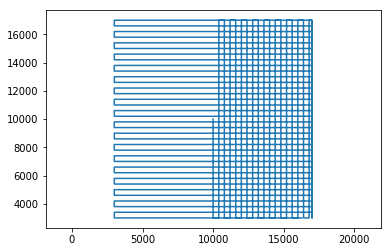

In [13]:
# Here's what it looks like plotted x versus y
#%matplotlib inline
#plt.figure(figsize=(10,10))
plt.plot(x_stage[wh1_5],y_stage[wh1_5])
plt.axis('equal')
plt.show()

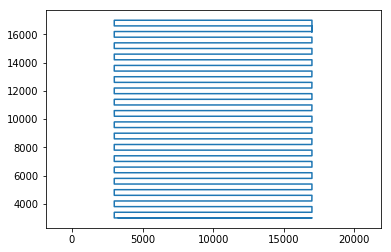

In [14]:
# Here's what it looks like plotted x versus y
#%matplotlib inline
#plt.figure(figsize=(10,10))
plt.plot(x_stage[wh2_5],y_stage[wh2_5])
plt.axis('equal')
plt.show()

In [15]:
# Let's focus on that second chunk
t_s2_5 = t5[wh2_5]
x_s2 = interp1d(t_s2_5, x_stage[wh2_5], kind='nearest')
y_s2 = interp1d(t_s2_5, y_stage[wh2_5], kind='nearest')

In [37]:
len(x_s), len(m)

(1014649, 1014649)

In [16]:
# Make a cut version of the data just during the good bit
t = t488[wh2_488]
m = mag[wh2_488]
p = phs[wh2_488]
x_s = x_s2(t)
y_s = y_s2(t)

In [46]:
t

array([5041.000448, 5041.002496, 5041.004544, ..., 7118.995456,
       7118.997504, 7118.999552])

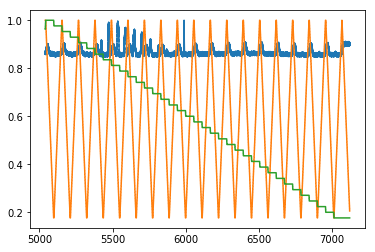

In [17]:
#%matplotlib inline
#plt.figure(figsize=(15,6))
#%matplotlib notebook
plt.plot(t,m/m.max())
plt.plot(t,x_s/x_s.max())
plt.plot(t,y_s/y_s.max())
plt.show()

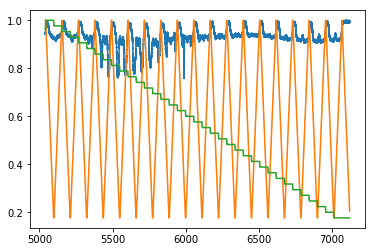

In [18]:
plt.plot(t,p/p.max())
plt.plot(t,x_s/x_s.max())
plt.plot(t,y_s/y_s.max())
plt.show()

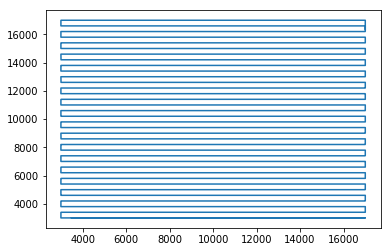

In [19]:
plt.plot(x_s,y_s)
plt.show()

In [20]:
# There's probably a better way to determine this based on the gradient in x,y 
# but it looks like the grid is about 250 x 250 in some units
#ds = 100.
#xpix = np.arange(x_s(t).min(),x_s(t).max(),ds)
#ypix = np.arange(y_s(t).min(),y_s(t).max(),ds)

In [21]:
#%%time
#zi = griddata((x_s(t), y_s(t)), m, (xpix[None,:], ypix[:,None]), method='nearest')

In [22]:
%%time
nbins = 70
mag_map_med = binned_statistic_2d(x_s, y_s, m, 'median',bins=nbins)
mag_map = binned_statistic_2d(x_s, y_s, m, 'mean',bins=nbins)
#phs_map = binned_statistic_2d(x_s, y_s, p, 'median',bins=nbins)

CPU times: user 5.45 s, sys: 60.4 ms, total: 5.51 s
Wall time: 5.29 s


//anaconda/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


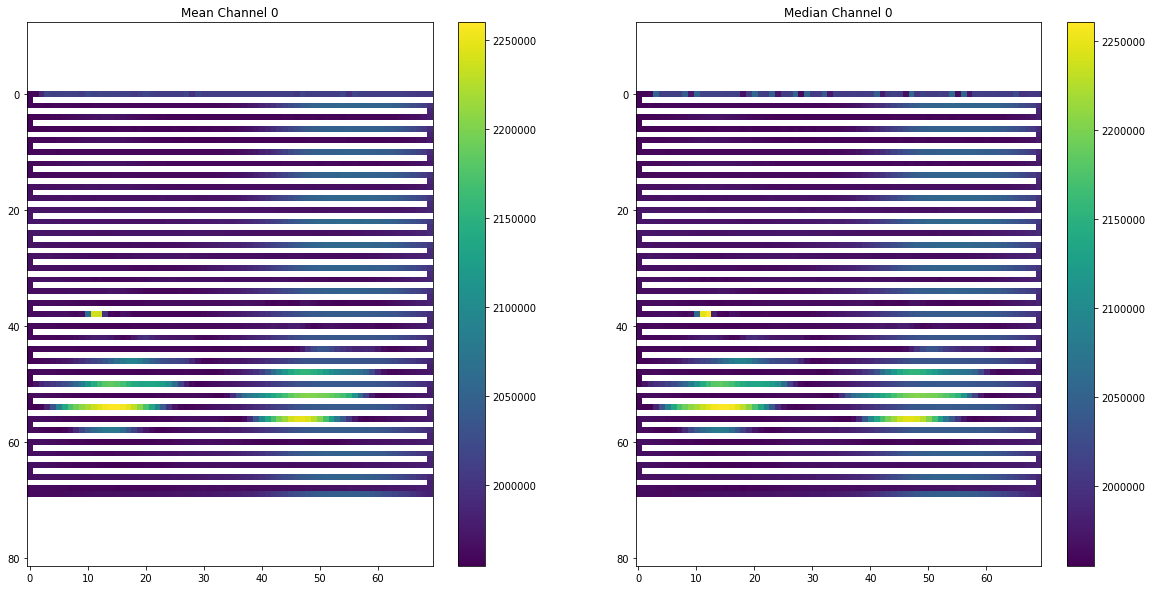

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(mag_map.statistic.T,aspect='auto')
plt.axis('equal')
plt.colorbar()
plt.title('Mean Channel '+str(chan))
plt.subplot(122)
plt.imshow(mag_map_med.statistic.T,aspect='auto')
plt.axis('equal')
plt.colorbar()
plt.title('Median Channel '+str(chan))
plt.show()
plt.savefig('channel'+str(chan).zfill(3)+'_'+which_scans+'.png')

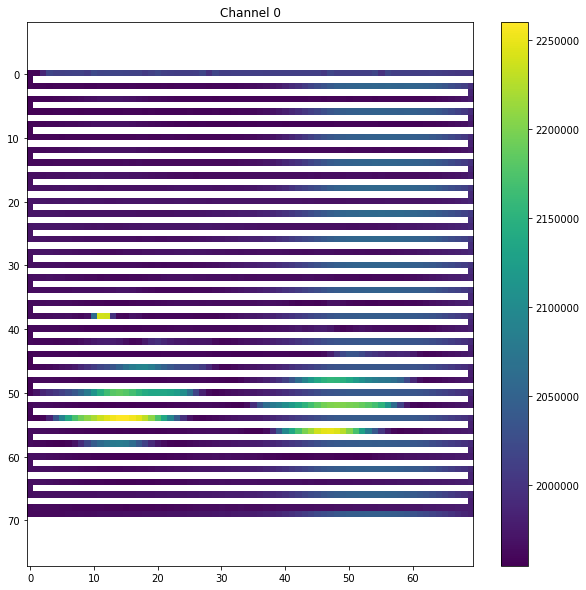

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(mag_map.statistic.T,aspect='auto')
plt.axis('equal')
plt.colorbar()
plt.title('Channel '+str(chan))
#plt.savefig('channel'+str(chan).zfill(3)+'_'+which_scans+'.png')
plt.show()

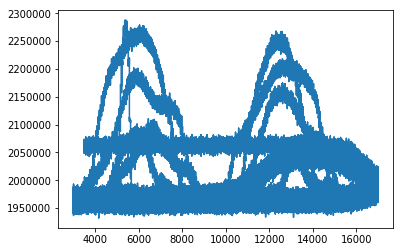

In [25]:
plt.plot(x_s,m)
plt.show()

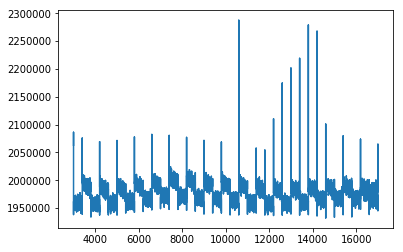

In [26]:
plt.plot(y_s,m)
plt.show()

The above two plots are probably the clearest statement of the problem: it looks like there are two different ranges of x and y for which the detector is responding.  If it's a single detector responding to a single light source, there should be only one ($x_0,y_0$) around which the detector responds.

In [27]:
x_stage.min()

0.0

In [28]:
x_stage.max()

17000.0

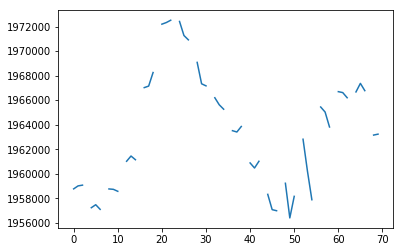

In [29]:
plt.plot(mag_map[0][0])

In [30]:
print mag_map[0][0][48], mag_map[1][48], mag_map[2][48]

1959224.2349484088 12600.0 12600.0


In [31]:
mag_map[0]

array([[1958767.62539864, 1959010.04138033, 1959071.05747369, ...,
                     nan, 1963152.52922452, 1963227.99094164],
       [1958890.00677475,              nan, 1958460.85936871, ...,
                     nan, 1963870.45322765, 1963177.85032874],
       [1987873.81378512,              nan, 1958943.36905566, ...,
                     nan, 1963099.24463098, 1962940.26671703],
       ...,
       [2004502.64192177,              nan, 2020158.147198  , ...,
                     nan, 1978057.70516944, 1992495.64376793],
       [2003951.71400835,              nan, 2012862.54176613, ...,
                     nan, 1979597.14917941, 1986222.14837948],
       [2003052.04707502,              nan, 1997756.71019142, ...,
        1980714.22872618, 1980254.15620638, 1981427.47989671]])

In [32]:
mag_map[1]

array([ 3000.,  3200.,  3400.,  3600.,  3800.,  4000.,  4200.,  4400.,
        4600.,  4800.,  5000.,  5200.,  5400.,  5600.,  5800.,  6000.,
        6200.,  6400.,  6600.,  6800.,  7000.,  7200.,  7400.,  7600.,
        7800.,  8000.,  8200.,  8400.,  8600.,  8800.,  9000.,  9200.,
        9400.,  9600.,  9800., 10000., 10200., 10400., 10600., 10800.,
       11000., 11200., 11400., 11600., 11800., 12000., 12200., 12400.,
       12600., 12800., 13000., 13200., 13400., 13600., 13800., 14000.,
       14200., 14400., 14600., 14800., 15000., 15200., 15400., 15600.,
       15800., 16000., 16200., 16400., 16600., 16800., 17000.])

In [33]:
mag_map

BinnedStatistic2dResult(statistic=array([[1958767.62539864, 1959010.04138033, 1959071.05747369, ...,
                     nan, 1963152.52922452, 1963227.99094164],
       [1958890.00677475,              nan, 1958460.85936871, ...,
                     nan, 1963870.45322765, 1963177.85032874],
       [1987873.81378512,              nan, 1958943.36905566, ...,
                     nan, 1963099.24463098, 1962940.26671703],
       ...,
       [2004502.64192177,              nan, 2020158.147198  , ...,
                     nan, 1978057.70516944, 1992495.64376793],
       [2003951.71400835,              nan, 2012862.54176613, ...,
                     nan, 1979597.14917941, 1986222.14837948],
       [2003052.04707502,              nan, 1997756.71019142, ...,
        1980714.22872618, 1980254.15620638, 1981427.47989671]]), x_edge=array([ 3000.,  3200.,  3400.,  3600.,  3800.,  4000.,  4200.,  4400.,
        4600.,  4800.,  5000.,  5200.,  5400.,  5600.,  5800.,  6000.,
        6200.,  6400., 